In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from glob import glob
from paprika.analysis import get_block_sem, get_nearest_max
from scipy.integrate import cumtrapz

### Lambda points

In [2]:
clambda = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
weights = np.array([1])
int_type = 'trapezoidal'
nTI = len(clambda)
skip = 50

### Collect dvdl data from logfile

In [3]:
dvdl_ti = []
dvdl_run_ave = []

for ti in range(nTI):
    production = glob(os.path.join(f'd{ti:03d}', 'production-v*.out'))
    dvdl_i = []
    dvdl_a = []
    dvdl = 0.0
    j = 0
    for prod in production:
        with open(prod, 'r') as file:        
            for line in file:                
                if "Summary of dvdl values over" in line:                    
                    for i in range(int(line.split()[-2])):
                        if i % skip == 0:
                            data = float(file.readline())
                            dvdl += data

                            dvdl_i.append(data)
                            dvdl_a.append(dvdl / (j+1))

                            j += 1

    dvdl_ti.append(dvdl_i)
    dvdl_run_ave.append(dvdl_a)

dvdl_ti = np.array(dvdl_ti)
dvdl_run_ave = np.array(dvdl_run_ave)

### Get average and block data sem

In [4]:
dvdl_avgs = np.zeros([clambda.size], np.float64)
dvdl_sems = np.zeros([clambda.size], np.float64)
dvdl_totn = np.zeros([clambda.size], np.int32)
dvdl_blkn = np.zeros([clambda.size], np.int32)

for i in range(nTI):
    dvdl_avgs[i] = np.mean(dvdl_ti[i,:])
    dvdl_totn[i] = dvdl_ti[i,:].size
    dvdl_blkn[i] = get_nearest_max(len(dvdl_ti[i]))
    dvdl_sems[i] = get_block_sem(dvdl_ti[i,:dvdl_blkn[i]])

### Bootstrapping

In [5]:
boot_cycles = 10000
fe_boot = np.zeros([boot_cycles], np.float64)
boot_dvdls = np.zeros([nTI, boot_cycles], np.float64)

for i in range(nTI):
    boot_dvdls[i,:] = np.random.normal(dvdl_avgs[i], dvdl_sems[i], boot_cycles)
    
for cycle in range(boot_cycles):
    fe_boot[cycle] = np.trapz(boot_dvdls[:,cycle], clambda)
    
fe_avgs = np.mean(fe_boot)
fe_sems = np.std(fe_boot)

print(f"Free-energy: {fe_avgs:.2f} +- {fe_sems:.2f} kcal/mol")

Free-energy: 4.01 +- 0.16 kcal/mol


### TI Results

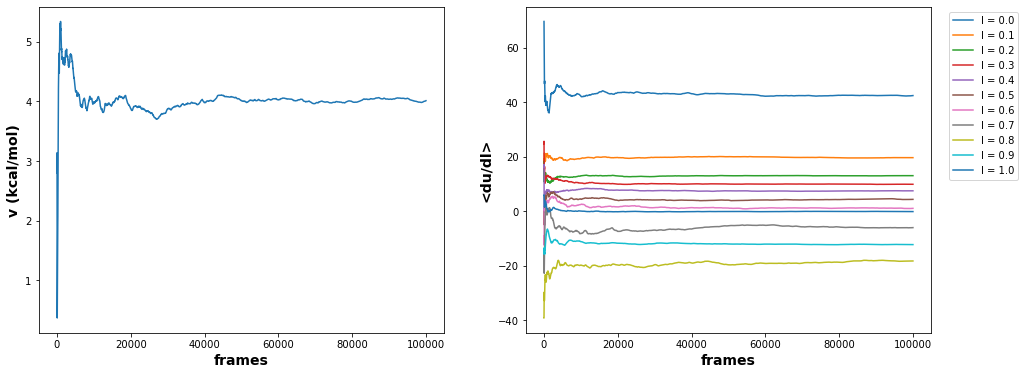

In [6]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
ndata = np.shape(dvdl_ti)[1]
TI = np.zeros(ndata)
for i in range(ndata):
    if int_type == 'trapezoidal':
        TI[i] = np.trapz(dvdl_run_ave[:,i], clambda)
        TI_int = cumtrapz(dvdl_avgs, x=clambda, initial=0)
    elif int_type == 'quadrature':
        TI[i] = np.sum(dvdl_run_ave[:,i] * weights)
        TI_int = np.cumsum(dvdl_avgs * weights)
    
plt.plot(TI)
plt.xlabel('frames', size=14, weight='bold')
plt.ylabel('v (kcal/mol)', size=14, weight='bold')

plt.subplot(1,2,2)
for i in range(nTI):
    plt.plot(dvdl_run_ave[i,:], label=f"l = {clambda[i]}")
    plt.xlabel('frames', size=14, weight='bold')
    plt.ylabel('<du/dl>', size=14, weight='bold')
plt.legend(bbox_to_anchor=(1.03, 1.0))

### Average dU/dl 

(0.0, 1.0)

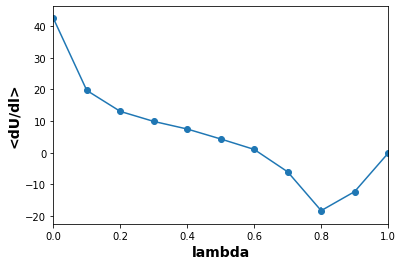

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.errorbar(clambda, dvdl_avgs, yerr=dvdl_sems, fmt='o-')
plt.xlabel('lambda', size=14, weight='bold')
plt.ylabel('<dU/dl>', size=14, weight='bold')
plt.xlim(0,1)

plt.subplot(1,2,2)
plt.plot(clambda, TI_int, 'o-')
plt.xlabel('lambda', size=14, weight='bold')
plt.ylabel('<U> (kcal/mol)', size=14, weight='bold')
plt.xlim(0,1)